In [10]:
import cvxpy as cp
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

In [3]:
n = 30 # number of waypoints
robot_initial_point, robot_goal_point, v_min, v_max = (30, 40), (350, 370), 5, 20 # (x, y)
dt = 1

In [5]:
class Robot:
    def __init__(self,x_start,y_start,x_goal,y_goal,v_min,v_max,obstacles=None, radius=None):
        self.x_start = x_start
        self.y_start = y_start
        self.x_goal = x_goal
        self.y_goal = y_goal
        self.v_min = v_min
        self.v_max = v_max
        self.x_dot = cp.Variable(n)
        self.y_dot = cp.Variable(n) 
        self.x = cp.Variable(n)
        self.y = cp.Variable(n)
        self.obstacles=obstacles
        self.radius=radius

    def set_constraints(self):
        constraints = [self.x[0] == self.x_start + self.x_dot[0]*dt, self.y[0] == self.y_start + self.y_dot[0]*dt]
        for i in range(n):
            if i != n - 1:
                constraints.append(self.x[i+1] == self.x[i] + self.x_dot[i]*dt)
                constraints.append(self.y[i+1] == self.y[i] + self.y_dot[i]*dt)
            constraints.append(self.v_min <= self.x_dot[i])
            constraints.append(self.x_dot[i] <= self.v_max)
            constraints.append(self.v_min <= self.y_dot[i])
            constraints.append(self.y_dot[i] <= self.v_max)
            # constraints.extend([self.x[i+1] == self.x[i] + self.x_dot[i]*dt, self.y[i+1] == self.y[i] + self.y_dot[i]*dt, self.v_min <= self.x_dot[i], self.x_dot[i] <= self.v_max, self.v_min <= self.y_dot[i], self.y_dot[i] <= self.v_max])
        return constraints

    def optimize(self):
        constraints=self.set_constraints()
        objective = cp.Minimize((self.x[n - 1] - self.x_goal)**2 + (self.y[n - 1] - self.y_goal)**2)
        prob = cp.Problem(objective, constraints)
        loss = prob.solve()
        return loss

    def set_constraints_obstacle(self,x_star_dot,y_star_dot,obstacles):
        constraints = []
        for i in range(n):
            constraints.append(-self.v_max <= self.x_dot[i])
            constraints.append(self.x_dot[i] <= self.v_max)
            constraints.append(-self.v_max <= self.y_dot[i])
            constraints.append(self.y_dot[i] <= self.v_max)
            constraints.append(self.x_start + cp.sum(self.x_dot[:i + 1]) >= 5)
            constraints.append(self.y_start + cp.sum(self.y_dot[:i + 1]) >= 5)
            for obs in range(len(obstacles)):
                x_term = (self.x_start + x_star_dot[:i+1].sum() * dt - obstacles[obs][0]) ** 2
                y_term = (self.y_start + y_star_dot[:i+1].sum() * dt - obstacles[obs][1]) ** 2
                fxy = -x_term - y_term + self.radius[obs]**2
                xgrad = np.ones(i + 1) * -2*dt*(self.x_start + x_star_dot[:i+1].sum() * dt - obstacles[obs][0])
                ygrad = np.ones(i + 1) * -2*dt*(self.y_start + y_star_dot[:i + 1].sum() * dt - obstacles[obs][1])
                constraints.append(fxy + xgrad.reshape(1, -1) @ (self.x_dot[:i+1] - x_star_dot[:i+1].reshape(-1, 1)) + ygrad.reshape(1, -1) @ (self.y_dot[:i+1] - y_star_dot[:i+1].reshape(-1, 1)) <= 0)
        return constraints


    def optimize_obstacles(self):
        if obstacles==None or radius==None:
            raise Exception("provide obstacle")
        x_star_dot = np.zeros(n) 
        y_star_dot = np.zeros(n)
        prev_loss = np.inf
        while True:
            self.x_dot = cp.Variable(shape = (n, 1))
            self.y_dot = cp.Variable(shape = (n, 1))
            constraints = self.set_constraints_obstacle(x_star_dot,y_star_dot,self.obstacles)
            objective = cp.Minimize((self.x_start + cp.sum(self.x_dot) * dt - self.x_goal) ** 2 + (self.y_start + cp.sum(self.y_dot) * dt - self.y_goal) ** 2)
            prob = cp.Problem(objective, constraints)
            loss = prob.solve()
            if prev_loss - loss <= 10: break
            prev_loss = loss
            x_star_dot = self.x_dot.value.flatten()
            y_star_dot = self.y_dot.value.flatten()




In [6]:
def visualizePath(x, y, myRobot, obstacles=None, radius=None, save=0):
    x=np.concatenate(([np.int64(myrobot.x_start)],x))
    y=np.concatenate(([np.int64(myrobot.y_start)],y))
    img_result = 255*np.ones(shape=(400, 400, 3)).astype(np.uint8)
    cv2.circle(img_result, (myrobot.x_start, myrobot.y_start), 5, (0,255,0), -1)
    cv2.circle(img_result, (myrobot.x_goal, myrobot.y_goal), 5, (0,0,255), -1)
    if(obstacles!=None):
        for i in range(len(obstacles)):
            cv2.circle(img_result, (obstacles[i][0],obstacles[i][1]), radius[i], (255,0,0), 1)
    for i in range(n):
        cv2.line(img_result, (x[i], y[i]), (x[i+1], y[i+1]), (0, 0, 0), 1)
        plt.imshow(img_result)
        plt.show()
        if save:
            print("saved")
            direc = f'./Obs_Images/result_{i}.jpg'
            cv2.imwrite(direc, img_result)

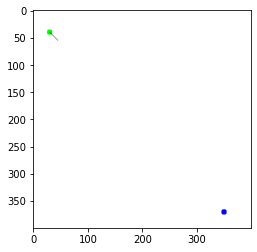

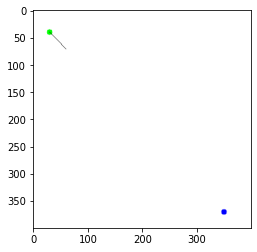

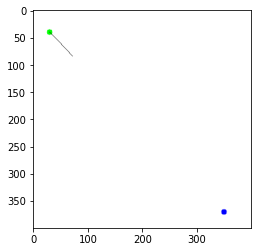

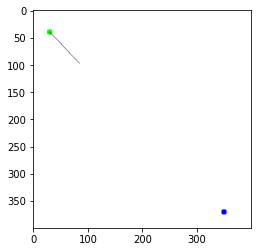

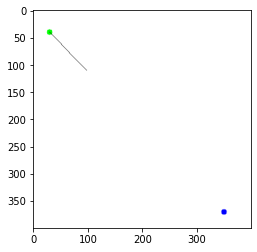

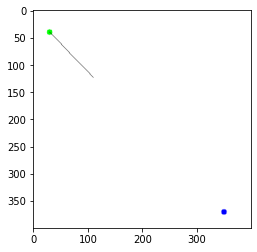

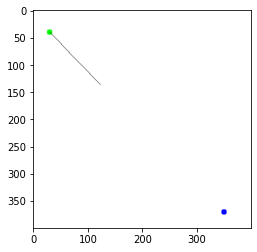

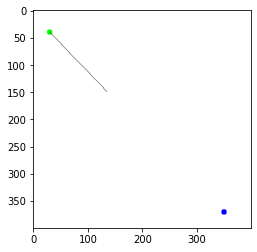

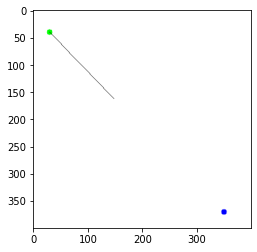

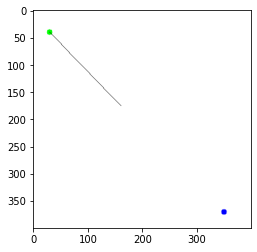

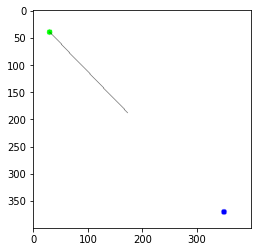

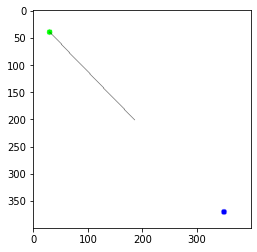

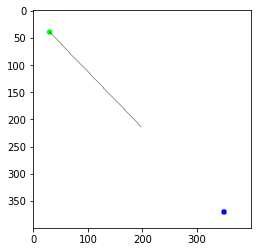

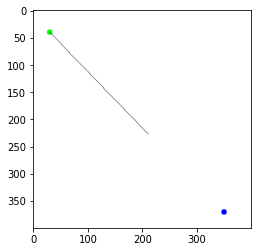

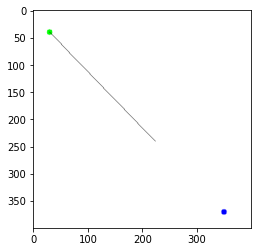

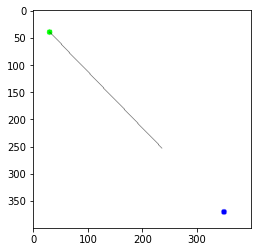

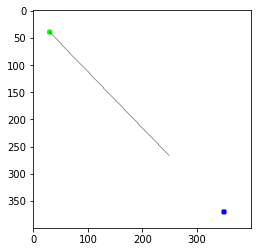

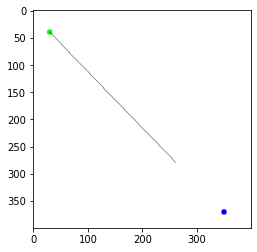

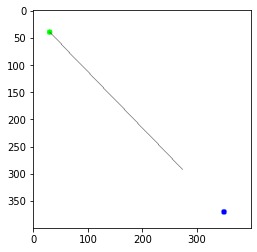

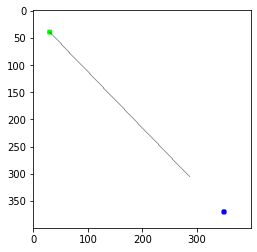

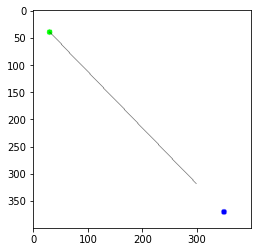

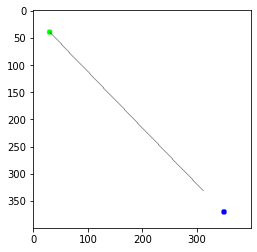

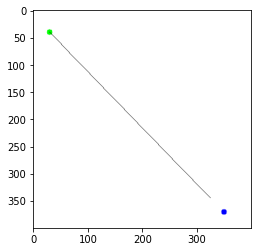

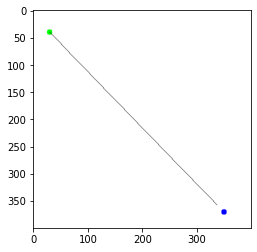

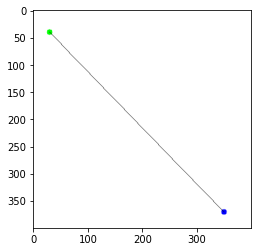

In [73]:
robot_initial_point = (30, 40)
robot_goal_point = (350, 370)
v_min=5
v_max=20
obstacles = [(200, 200), (75,250)]
radius = [75, 50]
dt = 1


myrobot = Robot(robot_initial_point[0],robot_initial_point[1],robot_goal_point[0],robot_goal_point[1],v_min,v_max,obstacles,radius)
myrobot.optimize()
x, y = np.round(myrobot.x.value).astype(np.int64), np.round(myrobot.y.value).astype(np.int64)

# x, y = np.round(robot_initial_point[0] + myrobot.x_dot.value.cumsum() * dt).astype(np.int64), np.round(robot_initial_point[1] + myrobot.y_dot.value.cumsum() * dt).astype(np.int64)
visualizePath(x, y, myrobot)
# print(myrobot.x.value)
# print(myrobot.y.value)

# print(myrobot.x_start + np.sum(myrobot.x_dot.value) * dt - myrobot.x_goal,robot_initial_point[1] + np.sum(myrobot.y_dot.value) * dt)

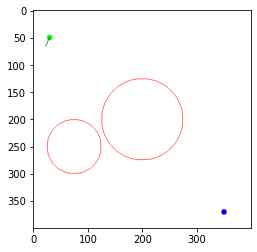

saved


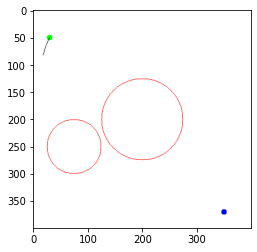

saved


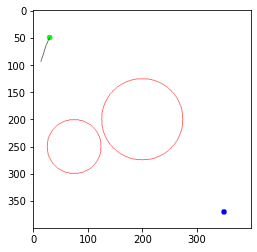

saved


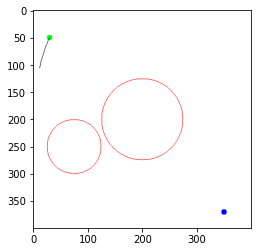

saved


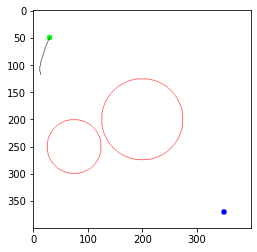

saved


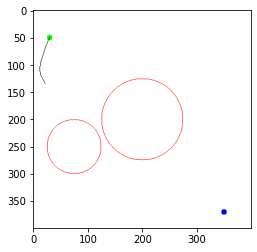

saved


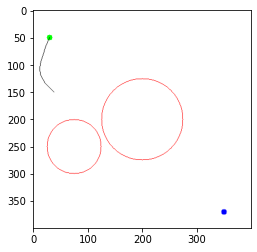

saved


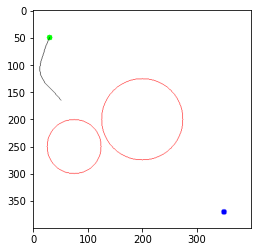

saved


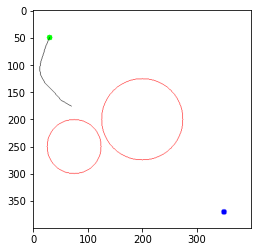

saved


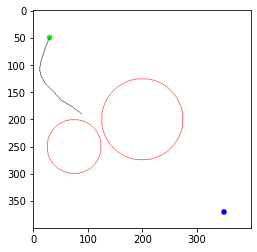

saved


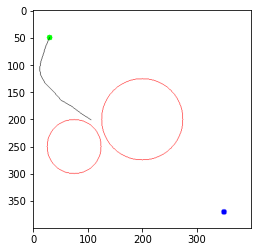

saved


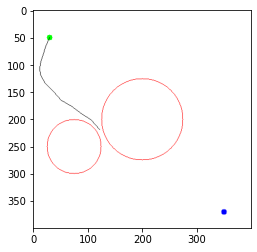

saved


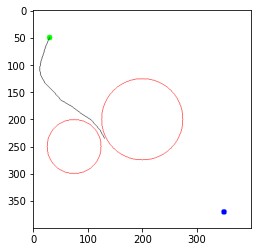

saved


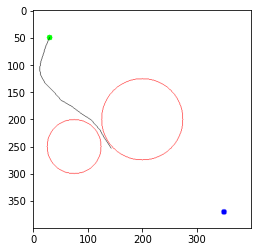

saved


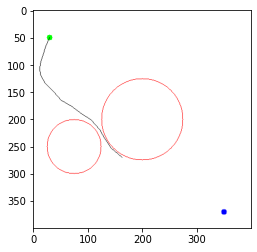

saved


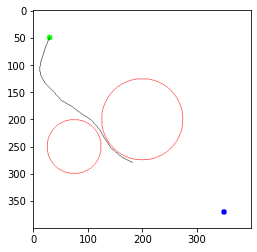

saved


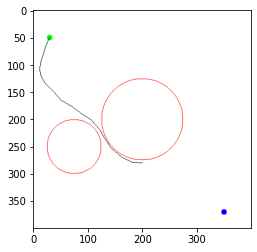

saved


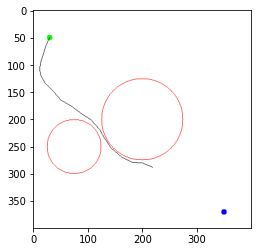

saved


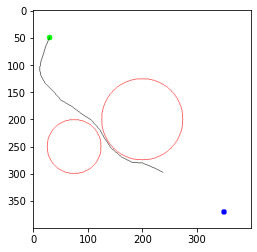

saved


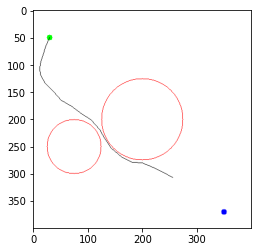

saved


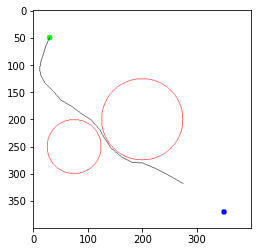

saved


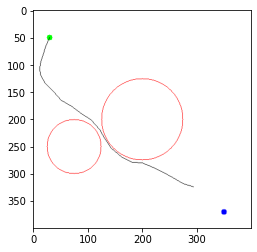

saved


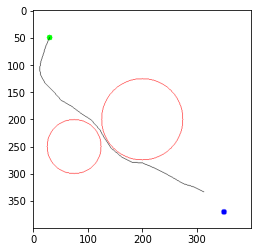

saved


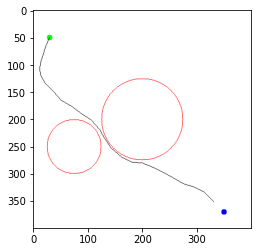

saved


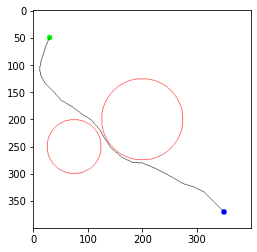

saved


In [8]:
robot_initial_point = (30, 50)
robot_goal_point = (350, 370)
v_min=5
v_max=20
obstacles = [(200, 200), (75,250)]
radius = [75, 50]
dt = 1
n = 25

myrobot = Robot(robot_initial_point[0],robot_initial_point[1],robot_goal_point[0],robot_goal_point[1],v_min,v_max,obstacles,radius)
myrobot.optimize_obstacles()
# x, y = np.round(myrobot.x.value).astype(np.int64), np.round(myrobot.y.value).astype(np.int64)

x, y = np.round(robot_initial_point[0] + myrobot.x_dot.value.cumsum() * dt).astype(np.int64), np.round(robot_initial_point[1] + myrobot.y_dot.value.cumsum() * dt).astype(np.int64)
visualizePath(x, y, myrobot,obstacles,radius,save=1)
# print(myrobot.x.value)
# print(myrobot.y.value)

# print(myrobot.x_start + np.sum(myrobot.x_dot.value) * dt - myrobot.x_goal,robot_initial_point[1] + np.sum(myrobot.y_dot.value) * dt)

25


True

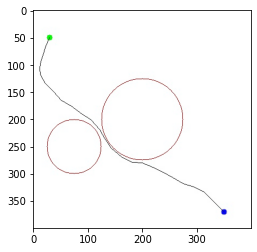

In [14]:

# parser = argparse.ArgumentParser(description='Converting Frames to Video and Vice Versa')
# parser.add_argument('--in', dest='input', required=True, help = "[--in \path\to\input\directory]")
# parser.add_argument('--out', dest='out', required=True, help="[--out \parh\to\output\directory]")

def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''

    # if not os.path.isdir(input_path):
    #     raise OSError(2, 'No such file or directory', input_path)
    #     return False

    # if not os.path.isdir(output_path):
    #     os.makedirs(output_path)

    image_files = sorted(glob(input_path))
    print(len(image_files))

    frames = []

    for i in range(len(image_files)):
        # f = f"{input_path}/{i}.png"
#         print(i)
        f = f"result_{i}.jpg" 
        
        frame = cv2.imread(f'./Obs_Images/result_{i}.jpg')
        plt.imshow(frame)
#         break
#         print(np.shape(frame))
        if frame is None:
            continue
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

frames_to_video("./Obs_Images/*.jpg","./Without_Obs_Images/Obs.mp4", 25)